Import what's required

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn import cross_validation
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import seaborn as sns
import glob
import os
from sklearn.preprocessing import binarize
from sklearn.cross_validation import cross_val_score
plt.style.use('ggplot')

c:\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Read csv

In [21]:
#full_results = pd.read_csv('E0.csv')
full_results = pd.read_csv('overall.csv')
#full_results.head()

In [22]:
fixtures = pd.read_csv('fixtures.csv')

In [23]:
"""
fixtures = fixtures[['Date','Div','HomeTeam']]
fixtures['2GameForm'] = ''
fixtures['2GameGoalsFor'] = ''
fixtures['2GameGoalDiff'] = ''
"""

"\nfixtures = fixtures[['Date','Div','HomeTeam']]\nfixtures['2GameForm'] = ''\nfixtures['2GameGoalsFor'] = ''\nfixtures['2GameGoalDiff'] = ''\n"

A function to calculate the result 

In [6]:
def result(x):
	conditions = [
	(x['GoalsFor'] > x['GoalsAgainst']),
	(x['GoalsFor'] == x['GoalsAgainst']),
	(x['GoalsFor'] < x['GoalsAgainst'])
	]
	choices = [1,0,-1]
	x['Result'] = np.select(conditions, choices)
	return x

def home_win(x):
	conditions = [
	(x['HomeGoalsFor'] > x['HomeGoalsAgainst']),
	(x['HomeGoalsFor'] <= x['HomeGoalsAgainst'])
	]
	choices = [1,0]
	x['Home_Win'] = np.select(conditions, choices)
	return x

def draw(x):
	conditions = [
	(x['HomeGoalsFor'] == x['HomeGoalsAgainst']),
	(x['HomeGoalsFor'] != x['HomeGoalsAgainst'])
	]
	choices = [1,0]
	x['Draw'] = np.select(conditions, choices)
	return x

def away_win(x):
	conditions = [
	(x['HomeGoalsAgainst'] > x['HomeGoalsFor']),
	(x['HomeGoalsAgainst'] <= x['HomeGoalsFor'])
	]
	choices = [1,0]
	x['Away_Win'] = np.select(conditions, choices)
	return x

def home_or_draw(x):
	conditions = [
	(x['HomeGoalsFor'] >= x['HomeGoalsAgainst']),
	(x['HomeGoalsFor'] < x['HomeGoalsAgainst'])
	]
	choices = [1,0]
	x['Home_Draw'] = np.select(conditions, choices)
	return x

In [7]:
def joined_result(x):
    if x == 'H':
        return 1
    elif x == 'D':
        return 0
    elif x == 'A':
        return -1

In [8]:
joined_result('H')

1

Define dataframes

In [9]:
full_stats = full_results[['Date','Div','HomeTeam','AwayTeam','FTHG','FTAG','FTR']]
home_stats = full_results.set_index(['Date','Div','HomeTeam'])
away_stats = full_results.set_index(['Date','Div','AwayTeam'])

In [10]:
home_stats = home_stats[['FTHG','FTAG']]
home_stats.rename(columns={'FTHG':'GoalsFor','FTAG':'GoalsAgainst'},inplace='True')
home_stats['GoalDiff'] = home_stats['GoalsFor'] - home_stats['GoalsAgainst']
away_stats = away_stats[['FTAG','FTHG']]
away_stats.rename(columns={'FTAG':'GoalsFor','FTHG':'GoalsAgainst'},inplace='True')
away_stats['GoalDiff'] = away_stats['GoalsFor'] - away_stats['GoalsAgainst']

Set dataframes with the result

In [11]:
home_stats = result(home_stats)
away_stats = result(away_stats)

In [12]:
home_stats.tail()

GoalsFor  GoalsAgainst  GoalDiff  Result
Date     Div HomeTeam                                             
03/06/17 T1  Besiktas            4             0         4       1
             Galatasaray         2             1         1       1
             Kayserispor         0             1        -1      -1
             Rizespor            1             0         1       1
             Trabzonspor         1             2        -1      -1

In [13]:
home_stats.rename(columns={'GoalsFor':'HomeGoalsFor','GoalsAgainst':'HomeGoalsAgainst','GoalDiff':'HomeGoalDiff','Result':'HomeResult'},inplace='True')
away_stats.rename(columns={'GoalsFor':'AwayGoalsFor','AwayGoalsAgainst':'AwayGoalsAgainst','GoalDiff':'AwayGoalDiff','Result':'AwayResult'},inplace='True')

In [14]:
for num in range(2,7):
        home = 'Home'
        away = 'Away'
        HomeGameForm="%s%sGameForm" % (home,num)
        HomeGameGoalsFor="%s%sGameGoalsFor" % (home,num)
        HomeGameGoalDiff="%s%sGameGoalDiff" % (home,num)
        AwayGameForm="%s%sGameForm" % (away,num)
        AwayGameGoalsFor="%s%sGameGoalsFor" % (away,num)
        AwayGameGoalDiff="%s%sGameGoalDiff" % (away,num)
        home_stats[HomeGameForm] = home_stats['HomeResult'].groupby(level='HomeTeam').apply(lambda x: pd.rolling_mean(x.shift(),num))
        home_stats[HomeGameGoalsFor] = home_stats['HomeGoalsFor'].groupby(level='HomeTeam').apply(lambda x: pd.rolling_mean(x.shift(),num))
        home_stats[HomeGameGoalDiff] = home_stats['HomeGoalDiff'].groupby(level='HomeTeam').apply(lambda x: pd.rolling_mean(x.shift(),num))
        away_stats[AwayGameForm] = away_stats['AwayResult'].groupby(level='AwayTeam').apply(lambda x: pd.rolling_mean(x.shift(),num))
        away_stats[AwayGameGoalsFor] = away_stats['AwayGoalsFor'].groupby(level='AwayTeam').apply(lambda x: pd.rolling_mean(x.shift(),num))
        away_stats[AwayGameGoalDiff] = away_stats['AwayGoalDiff'].groupby(level='AwayTeam').apply(lambda x: pd.rolling_mean(x.shift(),num))

In [15]:
home_noindex = home_stats.reset_index()
away_noindex = away_stats.reset_index()
#full_results
home_merge = pd.merge(full_stats, home_noindex, on=['Date','Div','HomeTeam'])
home_away_merge = pd.merge(home_merge, away_noindex, on=['Date','Div','AwayTeam'])
home_away_merge.tail()

,Date,Div,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeGoalsFor,HomeGoalsAgainst,HomeGoalDiff,...,Away3GameGoalDiff,Away4GameForm,Away4GameGoalsFor,Away4GameGoalDiff,Away5GameForm,Away5GameGoalsFor,Away5GameGoalDiff,Away6GameForm,Away6GameGoalsFor,Away6GameGoalDiff
7805,03/06/17,T1,Besiktas,Osmanlispor,4,0,H,4,0,4,...,-0.666667,0.0,1.25,0.25,-0.2,1.4,0.0,-0.333333,1.166667,-0.166667
7806,03/06/17,T1,Galatasaray,Konyaspor,2,1,H,2,1,1,...,-0.333333,0.0,1.25,0.00,0.2,1.2,0.2,0.000000,1.000000,-0.166667
7807,03/06/17,T1,Kayserispor,Buyuksehyr,0,1,A,0,1,-1,...,0.333333,0.0,1.25,0.00,0.2,1.6,0.6,0.333333,1.500000,0.666667
7808,03/06/17,T1,Rizespor,Alanyaspor,1,0,H,1,0,1,...,-1.666667,0.0,1.50,-1.00,0.2,1.8,-0.4,0.000000,1.666667,-0.500000
7809,03/06/17,T1,Trabzonspor,Bursaspor,1,2,A,1,2,-1,...,-3.666667,-1.0,0.50,-3.25,-0.8,0.6,-2.6,-0.833333,0.500000,-2.833333


In [16]:
home_away_merge_idx = home_away_merge.set_index(['Date','Div','HomeTeam','AwayTeam','FTR'])

Check Best Correlation

In [17]:
#home_away_merge_idx.corr()['HomeResult']

select relevant columns

In [18]:
home_away_merge_idx['3GameFormDiff'] = home_away_merge_idx['Home3GameForm'] - home_away_merge_idx['Away3GameForm']
home_away_merge_idx_relevant = home_away_merge_idx[['FTHG','FTAG','HomeResult','3GameFormDiff']]
#home_away_merge_cleaned = home_away_merge_idx_relevant.dropna()

In [19]:
for num in range(2,7):
        home = 'Home'
        away = 'Away'
        HomeGameForm="%s%sGameForm" % (home,num)
        HomeGameGoalsFor="%s%sGameGoalsFor" % (home,num)
        HomeGameGoalDiff="%s%sGameGoalDiff" % (home,num)
        AwayGameForm="%s%sGameForm" % (away,num)
        AwayGameGoalsFor="%s%sGameGoalsFor" % (away,num)
        AwayGameGoalDiff="%s%sGameGoalDiff" % (away,num)
        GameFormDiff = "%sGameFormDiff" % (num)
        GameGoalsForDiff = "%sGameGoalsForDiff" % (num)
        GameGoalDiffDiff = "%sGameGoalDiffDiff" % (num)
        home_away_merge_idx[GameFormDiff] = home_away_merge_idx[HomeGameForm] - home_away_merge_idx[AwayGameForm]
        home_away_merge_idx[GameGoalsForDiff] = home_away_merge_idx[HomeGameGoalsFor] - home_away_merge_idx[AwayGameGoalsFor]
        home_away_merge_idx[GameGoalDiffDiff] = home_away_merge_idx[HomeGameGoalDiff] - home_away_merge_idx[AwayGameGoalDiff]

In [20]:
home_away_merge_cleaned = home_away_merge_idx.fillna(value=-9999)

In [23]:
home_away_merge_cleaned = home_win(home_away_merge_cleaned)
home_away_merge_cleaned = draw(home_away_merge_cleaned)
home_away_merge_cleaned = away_win(home_away_merge_cleaned)
home_away_merge_cleaned = home_or_draw(home_away_merge_cleaned)

# Logistic Regression on HomeResult

In [24]:
logreg = LogisticRegression()

In [25]:
for num in range(2,7):
    X_GameFormDiff = "%sGameFormDiff" % (num)
    X_GameGoalsForDiff = "%sGameGoalsForDiff" % (num)
    X_GameGoalDiffDiff = "%sGameGoalDiffDiff" % (num)
    y = home_away_merge_cleaned['Home_Draw']
    X = home_away_merge_cleaned[[X_GameFormDiff, X_GameGoalsForDiff, X_GameGoalDiffDiff]]
    print(cross_val_score(logreg, X, y, cv=10, scoring='precision').mean())

0.712929907153
0.714235986077
0.713558873682
0.714295166046
0.714458800344


In [26]:
y = home_away_merge_cleaned['Home_Draw']
X = home_away_merge_cleaned[['3GameFormDiff', '3GameGoalsForDiff', '3GameGoalDiffDiff']]

In [27]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

In [28]:
#X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
logreg.fit(X_train, y_train)
#logreg.score(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
y_pred = logreg.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.70806658130601796

In [30]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [31]:
y_test.value_counts()

1    1104
0     458
Name: Home_Draw, dtype: int64

Text(0,0.5,'Frequency')

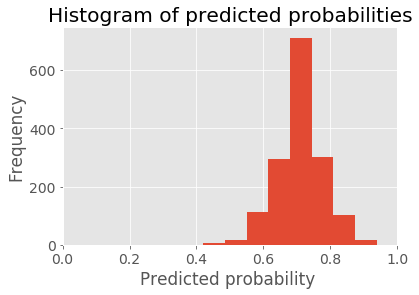

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
# histogram of predicted probabilities
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability ')
plt.ylabel('Frequency')

In [33]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)
logreg.fit(X_train, y_train)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
y_pred = binarize([y_pred_prob], 0.85)[0]
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
#Precision Value
#print(TP / float(TP + FP))
print(metrics.precision_score(y_test, y_pred))

[[ 666    6]
 [1644   27]]
0.818181818182


In [34]:
prediction_df = pd.DataFrame(y_pred)
prediction_df.rename(columns={0:'Predicted_Result'},inplace='True')
X_test_df = pd.DataFrame(X_test)
X_test_df = X_test_df.reset_index()
X_test_df
joined_pred = X_test_df.join(prediction_df)
#joined_pred
#joined_pred[['Date','HomeTeam','AwayTeam','FTR','Predicted_Result']]
joined_pred[['Date','HomeTeam','AwayTeam','FTR','Predicted_Result']].loc[joined_pred['Predicted_Result'] == 1].head()

,Date,HomeTeam,AwayTeam,FTR,Predicted_Result
28,18/03/17,Hoffenheim,Leverkusen,H,1.0
93,04/03/17,Panathinaikos,Veria,H,1.0
142,15/04/17,Dortmund,Ein Frankfurt,H,1.0
156,15/04/17,Monaco,Dijon,H,1.0
164,18/03/17,St Pauli,Hannover,D,1.0


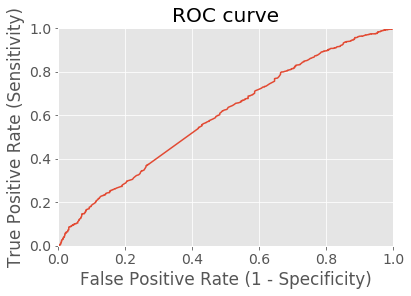

In [35]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [36]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])
    

evaluate_threshold(0.6)

Sensitivity: 0.952124476361
Specificity: 0.114583333333


In [37]:
prediction = logreg.predict(merged_new_indexed)
prediction_df = pd.DataFrame(prediction)
prediction_df.rename(columns={0:'Predicted_Result'},inplace='True')
joined_pred = merged_new_noindex.join(prediction_df)
joined_pred[['Date','HomeTeam','AwayTeam','Predicted_Result']]
prob_pred = logreg.predict_proba(merged_new_indexed)
prob_df = pd.DataFrame(prob_pred)
prob_df.rename(columns={0:'AwayWinProb',1:'DrawProb',2:'HomeWinProb'},inplace='True')
joined_pred_prod = joined_pred.join(prob_df)
joined_pred_prod[['Date','HomeTeam','AwayTeam','Predicted_Result','HomeWinProb','DrawProb','AwayWinProb']]

NameError: name 'merged_new_indexed' is not defined

In [ ]:
home_away_merge_cleaned_noind = home_away_merge_cleaned.reset_index()
home_away_merge_cleaned_prem = home_away_merge_cleaned_noind.loc[home_away_merge_cleaned_noind['Div'] == 'E0']
home_away_merge_cleaned_prem_idx = home_away_merge_cleaned_prem.set_index(['Date','Div','HomeTeam','AwayTeam'])
home_away_merge_cleaned_prem_idx_tail = home_away_merge_cleaned_prem_idx.tail(10)
home_away_merge_cleaned_prem_idx_tail

In [ ]:
home_away_merge_cleaned_prem_idx_tail_clean = home_away_merge_cleaned_prem_idx_tail[['2GameFormDiff', '2GameGoalsForDiff', '2GameGoalDiffDiff',
    '3GameFormDiff', '3GameGoalsForDiff', '3GameGoalDiffDiff',
    '4GameFormDiff', '4GameGoalsForDiff', '4GameGoalDiffDiff',
    '5GameFormDiff', '5GameGoalsForDiff', '5GameGoalDiffDiff',
    '6GameFormDiff', '6GameGoalsForDiff', '6GameGoalDiffDiff']]

In [ ]:
probs = logreg.predict_proba(home_away_merge_cleaned_prem_idx_tail_clean)

In [ ]:
probs_df = pd.DataFrame(probs)
probs_df = probs_df[2]
probs_df

# Linear Regression on Goals Scored

In [ ]:
home_stats.tail()
home_stats_clean=home_stats.dropna()

In [ ]:
sns.pairplot(home_stats_clean, x_vars=['Home3GameGoalsFor'], y_vars='HomeGoalsFor', size=7, aspect=0.7, kind='reg')

In [ ]:
# create a Python list of feature names
feature_cols = ['Home3GameGoalsFor','Home4GameGoalsFor']
# use the list to select a subset of the original DataFrame
X = home_stats_clean[feature_cols]
X.head()

In [ ]:
# check the type and shape of X
print(type(X))
print(X.shape)

In [ ]:
# equivalent command that works if there are no spaces in the column name
y = home_stats_clean.HomeResult

# print the first 5 values
y.head()

In [ ]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# default split is 75% for training and 25% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
# instantiate
linreg = LinearRegression()
# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

In [ ]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

In [ ]:
# make predictions on the testing set
y_pred = linreg.predict(X_test)
#type(y_pred)
y_pred_floor = np.rint(y_pred)
y_pred_floor

In [ ]:
# calculate RMSE using scikit-learn
np.sqrt(metrics.mean_squared_error(y_test, y_pred_floor))

In [ ]:
# 10-fold cross-validation with all features
lm = LinearRegression()
scores = cross_val_score(lm, X, y, cv=10, scoring='mean_squared_error')
print(scores)

In [ ]:
# fix the sign of MSE scores
mse_scores = -scores
print(mse_scores)

In [ ]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print(rmse_scores)

In [ ]:
# calculate the average RMSE
print(rmse_scores.mean())